In [15]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Paramètres du modèle

input_shape = (256, 256, 3)  
num_classes = len(data.espece.unique())

data = pd.read_csv('data.csv')

data.head()

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
1,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
2,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
3,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
4,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab


### Division du jeu de données en 10 dataframes équilibrés

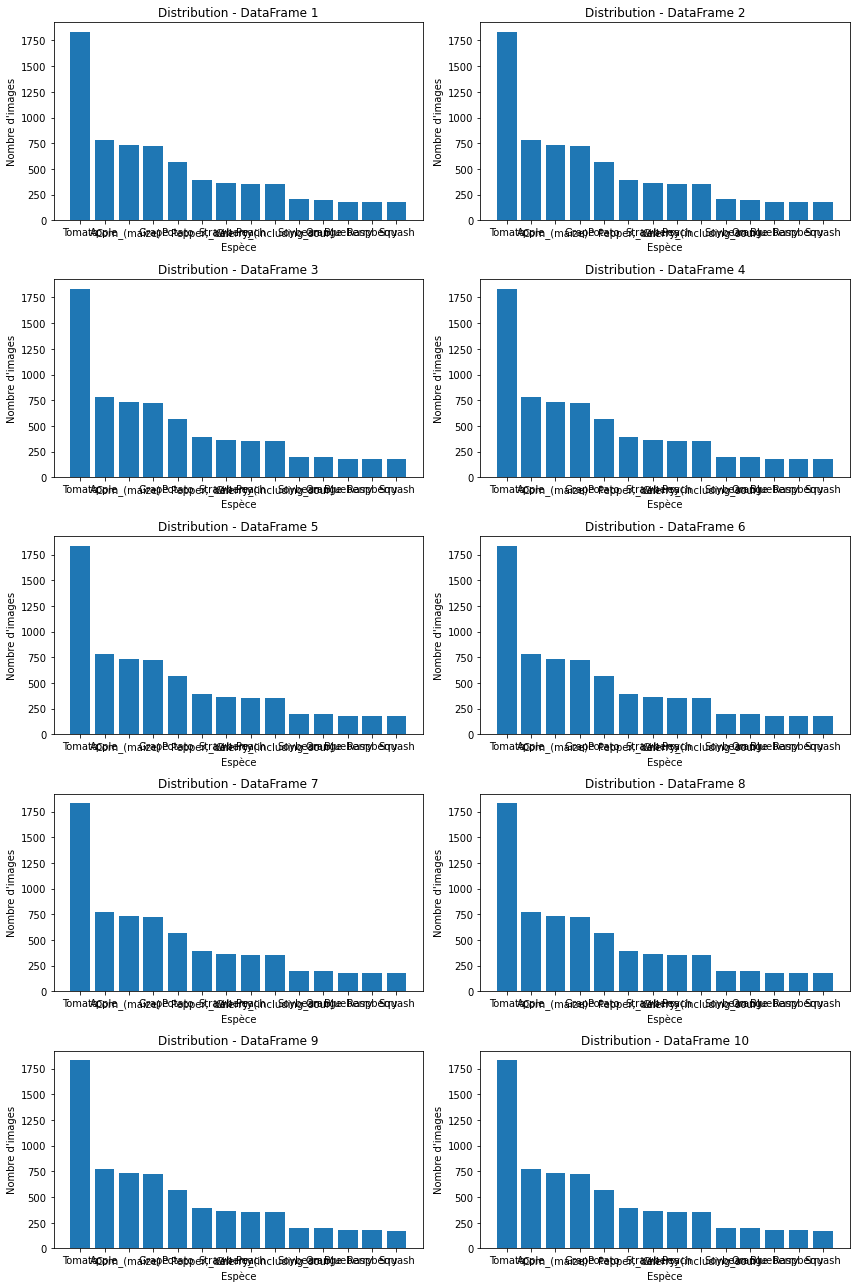

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data.drop(['espece', 'malade', 'nom_maladie'], axis=1)
y = data['espece']

dfs = []
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.9)
for train_index, _ in sss.split(X, y):
    df = pd.concat([X.iloc[train_index].reset_index(drop=True), y.iloc[train_index].reset_index(drop=True)], axis=1)
    dfs.append(df)

fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i, df in enumerate(dfs):
    value_counts = df['espece'].value_counts()
    
    row = i // 2
    col = i % 2
    
    axs[row, col].bar(value_counts.index, value_counts.values)
    axs[row, col].set_title(f"Distribution - DataFrame {i+1}")
    axs[row, col].set_xlabel("Espèce")
    axs[row, col].set_ylabel("Nombre d'images")

plt.tight_layout()
plt.show()

### Prétraitement des données 

In [17]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generators = []
validation_generators = []

for i in range(10):
    data_i = dfs[i]  
    
    train_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="espece",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical',
        subset='training'
    )
    train_generators.append(train_generator)
    
    validation_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="espece",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical',
        subset='validation'
    )
    validation_generators.append(validation_generator)

Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 56

### Modèle

In [8]:
# VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freezing

for layer in base_model.layers:
    layer.trainable = False

# Nouvelles couches 

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compilation

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
checkpoint_callback = ModelCheckpoint(
    'tf_VGG16_id_espece.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

# Boucle pour entraîner le modèle pour chaque data_i

for i in range(5):
    train_generator_i = train_generators[i]
    validation_generator_i = validation_generators[i]

    print(f"Entraînement du modèle pour data_{i+1} :")

    history = model.fit(
        train_generator_i,
        steps_per_epoch=train_generator_i.samples // train_generator_i.batch_size,
        epochs=8,
        validation_data=validation_generator_i,
        validation_steps=validation_generator_i.samples // validation_generator_i.batch_size,
        callbacks=[checkpoint_callback]
    )

    print(f"Fin de l'entraînement du modèle pour data_{i+1}.")
    print()

Entraînement du modèle pour data_1 :
Epoch 1/8
87/87 [==============================] - ETA: 0s - loss: 2.1490 - accuracy: 0.3214
Epoch 1: val_accuracy improved from -inf to 0.42336, saving model to tf_VGG16_id_espece.h5
87/87 [==============================] - 936s 11s/step - loss: 2.1490 - accuracy: 0.3214 - val_loss: 1.9056 - val_accuracy: 0.4234
Epoch 2/8
87/87 [==============================] - ETA: 0s - loss: 1.7176 - accuracy: 0.4867
Epoch 2: val_accuracy improved from 0.42336 to 0.58929, saving model to tf_VGG16_id_espece.h5
87/87 [==============================] - 986s 11s/step - loss: 1.7176 - accuracy: 0.4867 - val_loss: 1.4893 - val_accuracy: 0.5893
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 1.3450 - accuracy: 0.6200
Epoch 3: val_accuracy improved from 0.58929 to 0.65551, saving model to tf_VGG16_id_espece.h5
87/87 [==============================] - 944s 11s/step - loss: 1.3450 - accuracy: 0.6200 - val_loss: 1.1694 - val_accuracy: 0.6555
Epoch 4/8
87

Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.9531
Epoch 3: val_accuracy did not improve from 0.95387
87/87 [==============================] - 912s 10s/step - loss: 0.1695 - accuracy: 0.9531 - val_loss: 0.1778 - val_accuracy: 0.9412
Epoch 4/8
87/87 [==============================] - ETA: 0s - loss: 0.1603 - accuracy: 0.9549 
Epoch 4: val_accuracy did not improve from 0.95387
87/87 [==============================] - 3150s 37s/step - loss: 0.1603 - accuracy: 0.9549 - val_loss: 0.1692 - val_accuracy: 0.9501
Epoch 5/8
87/87 [==============================] - ETA: 0s - loss: 0.1580 - accuracy: 0.9554
Epoch 5: val_accuracy did not improve from 0.95387
87/87 [==============================] - 931s 11s/step - loss: 0.1580 - accuracy: 0.9554 - val_loss: 0.1618 - val_accuracy: 0.9501
Epoch 6/8
87/87 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9610
Epoch 6: val_accuracy did not improve from 0.95387
87/87 [======================

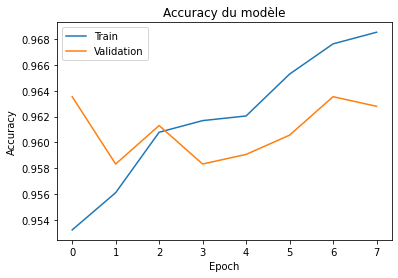

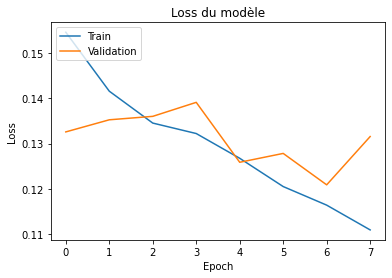

In [22]:
# Visualisation de l'accuracy du train et de la validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy du modèle')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Visualisation de la loss du train et de la validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss du modèle')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test du modèle sur les données de validation

In [23]:
data_test = pd.read_csv('data_test.csv')

data_test.head()
print(len(data_test.espece.unique()))

14


In [24]:
# Prétraitement des images

image_size = (256, 256)
batch_size = 64

datagen = ImageDataGenerator(rescale=1.0/255.0)

data_generator = datagen.flow_from_dataframe(
    dataframe=data_test,
    x_col='img_path',
    y_col='espece',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=False  
)


Found 17572 validated image filenames belonging to 14 classes.


In [26]:
# Chargement du modèle

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

model.load_weights('tf_VGG16_id_espece.h5')

# Compilation 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Sauvegarde du modèle

model.save('model_tf_VGG16_id_espece.h5')

In [27]:
# Prédictions

predictions = model.predict(data_generator)

275/275 [==============================] - 2302s 8s/step


In [28]:
import numpy as np

predicted_labels = np.argmax(predictions, axis=1)

In [29]:
true_labels = data_generator.classes
class_labels = data_generator.class_indices

Accuracy : 95.11%


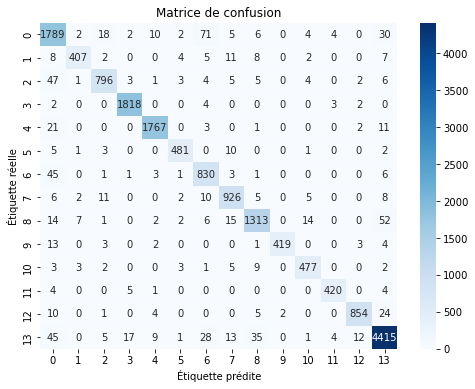

In [30]:
# Évaluation

from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy : {:.2f}%".format(accuracy * 100))

import seaborn as sns

confusion = confusion_matrix(true_labels, predicted_labels)

class_labels = np.unique(true_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matrice de confusion")
plt.xlabel("Étiquette prédite")
plt.ylabel("Étiquette réelle")
plt.show()